In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw
import yaml
from datetime import datetime, timedelta
from dateutil.parser import parse
from cmocean import cm
from tqdm import tqdm_notebook as tqdm
from dynmodes import dynmodes
from salishsea_tools import viz_tools
from scipy import signal
from warnings import simplefilter

%matplotlib inline
plt.rcParams['font.size'] = 11
simplefilter('ignore')

In [3]:
def calc_rho(data, depth, tmask):
    """Calculate the density, rho
    """
    
    rho = gsw.rho(*[np.ma.masked_where(tmask == 0, data[k]) for k in tracers], depth)
    
    return rho

In [4]:
def calc_deformation_radius(rho, z_h, bathy, radius=2, e1t=440, angle=0, tol=10):
    """Calculate the baroclinic Rossby deformation radius
    """

    g_prime = const['g'] * (const['rho_0'] - rho) / const['rho_0']
    R = np.sqrt(g_prime * z_h * (const['H'] - z_h) / const['H']) / const['f']
    H, H_old = const['H'], 0
    while abs(H - H_old) > tol:
        H_old = H
        H = bathy
        H = float(H[~np.isnan(H)][:int(radius * R / np.cos(angle) / e1t)].mean())
        R = np.sqrt(g_prime * z_h * (H - z_h) / H) / const['f']

    return R

In [5]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: subdomains, sections, dates_northerly, dates_southerly = yaml.safe_load_all(f)

bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
bathy = bathy.isel(x=slice(*subdomains['ideal'][:2]), y=slice(*subdomains['ideal'][2:]))
mask = mask.isel(x=slice(*subdomains['ideal'][:2]), y=slice(*subdomains['ideal'][2:]))
coords = coords.isel(x=slice(*subdomains['ideal'][:2]), y=slice(*subdomains['ideal'][2:]))

# Define path and filename string
path = '/data/bmoorema/results/Lake/S4d'
fn = 'SalishSeaIdeal_1h_20170701_20170706_grid_T.nc'
depth2d = np.expand_dims(mask.gdept_1d[0, :], axis=1)
tmask = mask.tmask[0, ...]
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10}
hour = 24
e1t = 440
radius = 2
tracers = ['vosaline', 'votemper']

# Define scaling parameters
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_surf': [1016, 1018, 1020],
}

# Build storage dict
runs = {}
for z_h in param['z_h']:
    runs[z_h] = {}
    for rho_s in param['rho_surf']:
        runs[z_h][rho_s] = {'R': []}
        for U in param['u_wind']:
            runs[z_h][rho_s][U] = {}
            for key in ['tau', 'z_u', 'x_u']:
                runs[z_h][rho_s][U][key] = []

In [6]:
# Make coastline indices
mask_trimmed = mask.tmask[0, ...].values
mask_trimmed[:, :130, :125] = 0
mask_trimmed[:, :50, :147] = 0
index = [147]
for row_s, row_d in zip(mask_trimmed[0, ...], mask_trimmed[30, ...]):
    i_s = np.where(np.diff(row_s) > 0)[0]
    i_d = np.where(np.diff(row_d) > 0)[0]
    if i_d.size:
        i_s = i_s[i_s < i_d[0]]
        if i_s.size: index.append(i_s[-1])
        else: index.append(index[-1])
    else: index.append(index[-1])
index = index[1:]
window = signal.get_window('blackman', 30)
index_smooth = signal.convolve(index, window / sum(window), mode='same')
slope = np.diff(index_smooth)

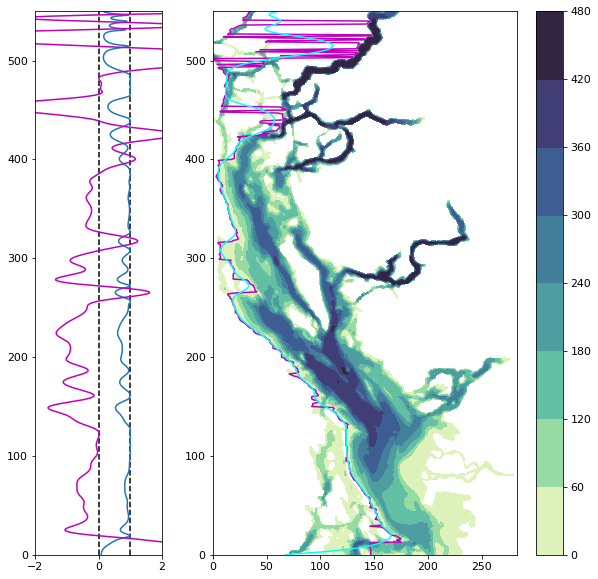

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [1, 3]})
axs[0].plot([0, 0], [0, 550], 'k--')
axs[0].plot([1, 1], [0, 550], 'k--')
axs[0].set_xlim([-2, 2])
for ax in axs:
    ax.set_ylim([0, 550])
axs[0].plot(slope, range(len(slope)))
c = axs[1].contourf(bathy.Bathymetry, cmap=cm.deep)
axs[1].plot(index, range(len(index)), 'm-')
axs[1].plot(index_smooth, range(len(index)), '-', color='cyan')
fig.colorbar(c)

In [8]:
# Loop though z_h, rho_surf and tau
for z_h in tqdm(param['z_h']):
    for rho_s in param['rho_surf']:
        
        # Calculate R
        for i, j, s in zip(index[:400][::10], np.arange(len(index[:400]))[::10], slope[:400][::10]):
            R = calc_deformation_radius(rho_s, z_h, bathy.Bathymetry[j, i:], e1t=e1t, angle=s, tol=10)
            runs[z_h][rho_s]['R'].append(R)
        
        # Loop through windspeed
        for U, t in zip(param['u_wind'], param['tau']):

            # Open results record
            runID = f'SalishSeaPond_S4d{U:02d}ms_halocline{z_h:2d}m_rhosurf{rho_s:4d}'
            file = os.path.join(path, runID, fn)
            if os.path.exists(file):
                with xr.open_dataset(file) as data:

                    # Loop through sections
                    for i, j, s, R in zip(index[:400][::10], np.arange(len(index[:400]))[::10], slope[:400][::10], runs[z_h][rho_s]['R']):
                        
                        # Lengthscale
                        L = int(radius * R / np.cos(np.arctan(s)) / e1t)
                        
                        # Calculate stratification parameters
                        rho_t0 = calc_rho(data.isel(time_counter=0, y=j, x=slice(i, None)), depth2d, tmask[:, j, i:])
                        rho_halo = rho_t0[abs(depth2d[:, 0] - z_h).argmin(axis=0), :L].mean()

                        # Calculate tau
                        tau = (hour - 3) * 3600 * np.sin(np.arctan(2) - np.arctan(s)) * t

                        # Calculate upwelling metrics
                        rho = calc_rho(data.isel(time_counter=hour, deptht=0, y=j, x=slice(i, None)), 0, tmask[0, j, i:])
                        rho_max = rho[:L].max()
                        z_u = depth2d[int(np.median(abs(rho_t0[:, :L] - rho_max).argmin(axis=0))), 0]
                        x_u = np.cos(np.arctan(s)) * (rho >= rho_halo).sum() * e1t
                        
                        for key, var in zip(['tau', 'z_u', 'x_u'], [tau, z_u, x_u]):
                            runs[z_h][rho_s][U][key].append(var)

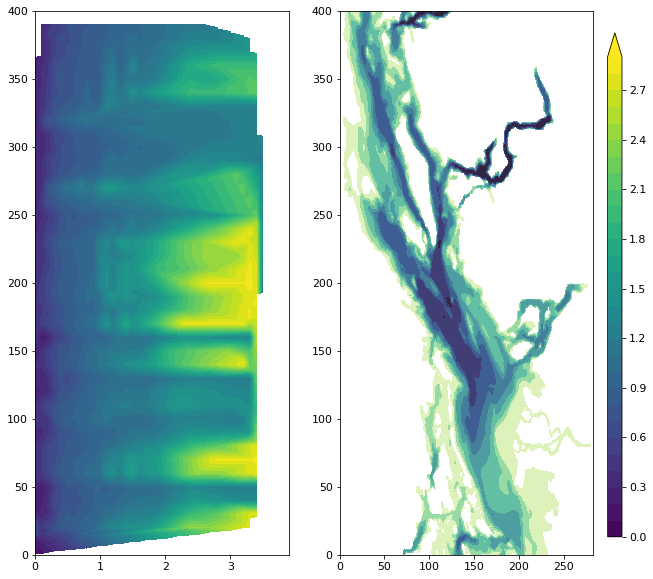

In [30]:
x, y, z = np.empty(0), np.empty(0), np.empty(0)
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
for ax in axs:
    ax.set_ylim([0, 400])

for z_h in param['z_h']:
    for rho_s in param['rho_surf']:
        for U in param['u_wind']:
            x = np.concatenate((x,
                np.array(runs[z_h][rho_s][U]['tau']) / (const['rho_0'] * const['f'] * z_h * np.array(runs[z_h][rho_s]['R'][:40])),
            ))
            y = np.concatenate((y, np.arange(len(index[:400]))[::10]))
            z = np.concatenate((z, np.array(runs[z_h][rho_s][U]['z_u']) / z_h))
            #c = axs[0].scatter(x, np.arange(len(index[:400]))[::10], s=40, c=z, vmin=0, vmax=2)

xi, yi = np.meshgrid(np.arange(0, 4, 0.1), np.arange(400))
data = griddata((x, y), z, (xi, yi), method='linear')
c = axs[0].contourf(xi, yi, data, levels=np.arange(0, 3, 0.1), extend='max')
axs[1].contourf(bathy.Bathymetry, cmap=cm.deep)
fig.colorbar(c, cax=cax)